In [1]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("daily_dialog")

In [2]:
from datasets import load_dataset

# Charger le dataset avec l'argument trust_remote_code
dataset = load_dataset("li2017dailydialog/daily_dialog", trust_remote_code=True)

README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [3]:
dataset['train'].to_csv("dailydialog_train.csv")
dataset['validation'].to_csv("dailydialog_validation.csv")
dataset['test'].to_csv("dailydialog_test.csv")

Creating CSV from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

561656

In [4]:
import re
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import pickle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_data=dataset['train']
test_data=dataset['test']
val_data=dataset['validation']

In [6]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
val_data = pd.DataFrame(val_data)

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Téléchargement des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', text)  # Supprimer les caractères spéciaux
    text = re.sub('\d+', '', text)              # Supprimer les chiffres
    text = text.lower()                         # Mettre en minuscules
    words = word_tokenize(text)                 # Tokenisation
    stop_words = set(stopwords.words('english'))  # Mots vides
    filtered_words = [word for word in words if word not in stop_words]  # Filtrage des mots vides
    return ' '.join(filtered_words)             # Retourner le texte nettoyé

# Appliquer le nettoyage aux ensembles de données
for dataset in [train_data, val_data, test_data]:
    dataset['cleaned_dialog'] = dataset['dialog'].apply(lambda x: [clean_text(turn) for turn in x])


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Créer des listes de textes nettoyés pour chaque ensemble de données
train_texts = [turn for dialog in train_data['cleaned_dialog'] for turn in dialog]
val_texts = [turn for dialog in val_data['cleaned_dialog'] for turn in dialog]
test_texts = [turn for dialog in test_data['cleaned_dialog'] for turn in dialog]

# Utiliser le tokenizer de TensorFlow
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)  # Fit seulement sur les données d'entraînement

# Générer des séquences de texte pour les ensembles de données
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Afficher un exemple de texte et sa séquence encodée
print('Text -->>', train_texts[0])
print('Embedding -->>', train_sequences[0])

# Padding des séquences
Max_Sequence_Len = max(max(len(seq) for seq in train_sequences),
                       max(len(seq) for seq in val_sequences),
                       max(len(seq) for seq in test_sequences))

train_sequences = pad_sequences(train_sequences, maxlen=Max_Sequence_Len, padding='pre')
val_sequences = pad_sequences(val_sequences, maxlen=Max_Sequence_Len, padding='pre')
test_sequences = pad_sequences(test_sequences, maxlen=Max_Sequence_Len, padding='pre')

# Afficher des informations sur les séquences
print('Maximum Sequence Length -->>', Max_Sequence_Len)
print('Train Sequence -->>\n', train_sequences[0])
print('Train Sequence Shape -->>', train_sequences.shape)

Text -->> say jim going beers dinner
Embedding -->> [70, 806, 23, 3067, 189]
Maximum Sequence Length -->> 117
Train Sequence -->>
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   70  806   23 3067  189]
Train Sequence Shape -->> (87170, 117)


In [9]:
# Préparer X et y pour l'entraînement
X_train = train_sequences[:, :-1]  # Toutes les colonnes sauf la dernière
y_train = train_sequences[:, -1]    # La dernière colonne

X_val = val_sequences[:, :-1]
y_val = val_sequences[:, -1]

X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]

In [10]:
from tensorflow.keras.utils import to_categorical

# One-Hot Encode y
total_words = len(tokenizer.word_index) + 1  # +1 pour le mot vide
y_train = to_categorical(y_train, num_classes=total_words)
y_val = to_categorical(y_val, num_classes=total_words)
y_test = to_categorical(y_test, num_classes=total_words)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

vocab_size = len(tokenizer.word_index) + 1
max_sequence_len = X_train.shape[1]

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_len))
model.add(SimpleRNN(256, return_sequences=True, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.4))  # Augmenter le Dropout
model.add(BatchNormalization())  # Normalisation de lot
model.add(SimpleRNN(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))  # Augmenter le Dropout
model.add(BatchNormalization())  # Normalisation de lot
model.add(Dense(vocab_size, activation='softmax'))


In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),
                    batch_size=64, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.4645 - loss: 7.8581 - val_accuracy: 0.5430 - val_loss: 5.1924 - learning_rate: 0.0010
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6458 - loss: 2.4669 - val_accuracy: 0.5430 - val_loss: 3.4081 - learning_rate: 0.0010
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7401 - loss: 1.7884 - val_accuracy: 0.8100 - val_loss: 2.4811 - learning_rate: 0.0010
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7798 - loss: 1.5017 - val_accuracy: 0.8590 - val_loss: 1.4854 - learning_rate: 0.0010
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8036 - loss: 1.2957 - val_accuracy: 0.8790 - val_loss: 1.2062 - learning_rate: 0.0010
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8297 - loss: 1.1121 - val_accuracy: 0.8960 - val_loss: 1.1132 - learning_rate: 0.0010
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8509 - loss: 0.9746 

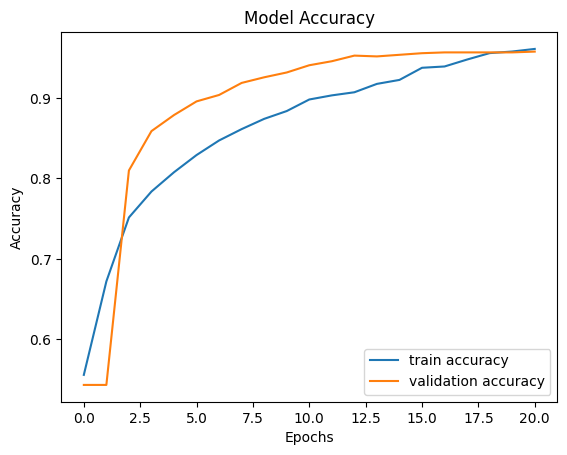

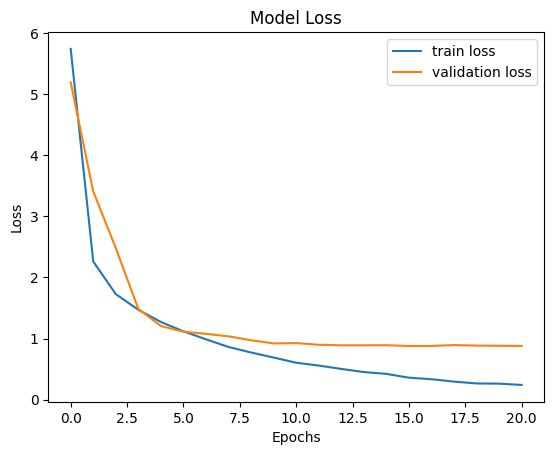

In [21]:
import matplotlib.pyplot as plt

# Visualiser l'exactitude
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualiser la perte
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9468 - loss: 1.5876
Test loss: 1.673708200454712, Test accuracy: 0.9430000185966492


In [91]:
# saving the model
model.save('sentence_completion.h5')

# saving the tokenizer
filename = 'tokenizer.pkl'
pickle.dump(tokenizer, open(filename, 'wb'))

In [1]:
def autoCompletations(text, model):
    # Tokenization and Text vectorization
    text_sequences = np.array(tokenizer.texts_to_sequences([text]))
    # Pre-padding
    testing = pad_sequences(text_sequences, maxlen = Max_Sequence_Len-1, padding='pre')
    # Prediction
    y_pred_test = np.argmax(model.predict(testing,verbose=0))
    
    predicted_word = ''
    for word, index in tokenizer.word_index.items():
        if index == y_pred_test:
            predicted_word = word
            break
    text += " " + predicted_word + '.'
    return text 
  
complete_sentence = autoCompletations('that sounds', model)
complete_sentence

NameError: name 'model' is not defined

In [106]:
def generate_text(text, new_words):
    for _ in range(new_words):
        text = autoCompletations(text, model)[:-1]
    return text 
  
generated_text = generate_text('sounds fine like', 9)
generated_text

'sounds fine like you do anything else available tonight it now walk'